In [1]:
from astroNN.datasets import galaxy10sdss
from astroNN.datasets.galaxy10 import galaxy10cls_lookup
import pandas as pd
import seaborn as sns
import numpy as np
from keras import utils
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import Dataset
import torchvision.transforms as transform




In [ ]:
images, labels=galaxy10sdss.load_data()

images=images.astype(np.float32)
Gal_train, Gal_test, lab_train, lab_test=train_test_split(images, labels, test_size=0.2)
Gal_train=Gal_train/255.0
Gal_test=Gal_test/255.0

In [3]:
Gal_train.shape, Gal_test.shape, lab_train.shape, lab_test.shape

((17428, 69, 69, 3), (4357, 69, 69, 3), (17428,), (4357,))

In [4]:

features=[feature for feature in galaxy10sdss.Galaxy10Class.values()]
    
for feature in features:
    print(feature)

Disk, Face-on, No Spiral
Smooth, Completely round
Smooth, in-between round
Smooth, Cigar shaped
Disk, Edge-on, Rounded Bulge
Disk, Edge-on, Boxy Bulge
Disk, Edge-on, No Bulge
Disk, Face-on, Tight Spiral
Disk, Face-on, Medium Spiral
Disk, Face-on, Loose Spiral


In [5]:
Ntransform=transform.Compose([transform.ToTensor()])

In [6]:
class Gal10Dataset(Dataset):
    def __init__(self, gal_data, labels, transform=None):
        self.gal_data=gal_data
        self.labels=labels
        self.transform=transform
    def __len__(self):
        return len(self.gal_data)
    def __getitem__(self,idx):
        sample=self.gal_data[idx]
        label=self.labels[idx]
        if self.transform:
            sample=self.transform(sample)
        return sample, label

In [7]:
train_set=Gal10Dataset(Gal_train, lab_train, transform=Ntransform)
test_set=Gal10Dataset(Gal_test,lab_test, transform=Ntransform)

imgs=torch.stack([img for img, _ in train_set], dim=0)
mean=imgs.view(1, -1).mean(dim=1)
std=imgs.view(1, -1).std(dim=1)
print(mean, std)

resize_norm=transform.Compose([transform.ToTensor(), transform.Resize((32, 32)), transform.Normalize(mean=mean, std=std)])

train_set=Gal10Dataset(Gal_train, lab_train, transform=resize_norm)
test_set=Gal10Dataset(Gal_test, lab_test, transform=resize_norm)

train_loader=DataLoader(train_set, batch_size=64, shuffle=True)
test_loader=DataLoader(test_set, batch_size=64, shuffle=True)

tensor([0.0911]) tensor([0.1267])


In [8]:
len(train_loader), len(test_loader)

(273, 69)

In [9]:
print(train_loader)
print(len(train_loader.dataset))
print(len(train_loader))
print(train_loader.batch_size)
for x, y in train_loader:
    print(x.shape, x.dtype, y.shape)
    break

17428
273
64
torch.Size([64, 3, 32, 32]) torch.float32 torch.Size([64])


In [10]:
for images, labels in train_loader:
    print(images.shape, images.dtype)
    print(labels.shape, labels.dtype)
    break

torch.Size([64, 3, 32, 32]) torch.float32
torch.Size([64]) torch.uint8


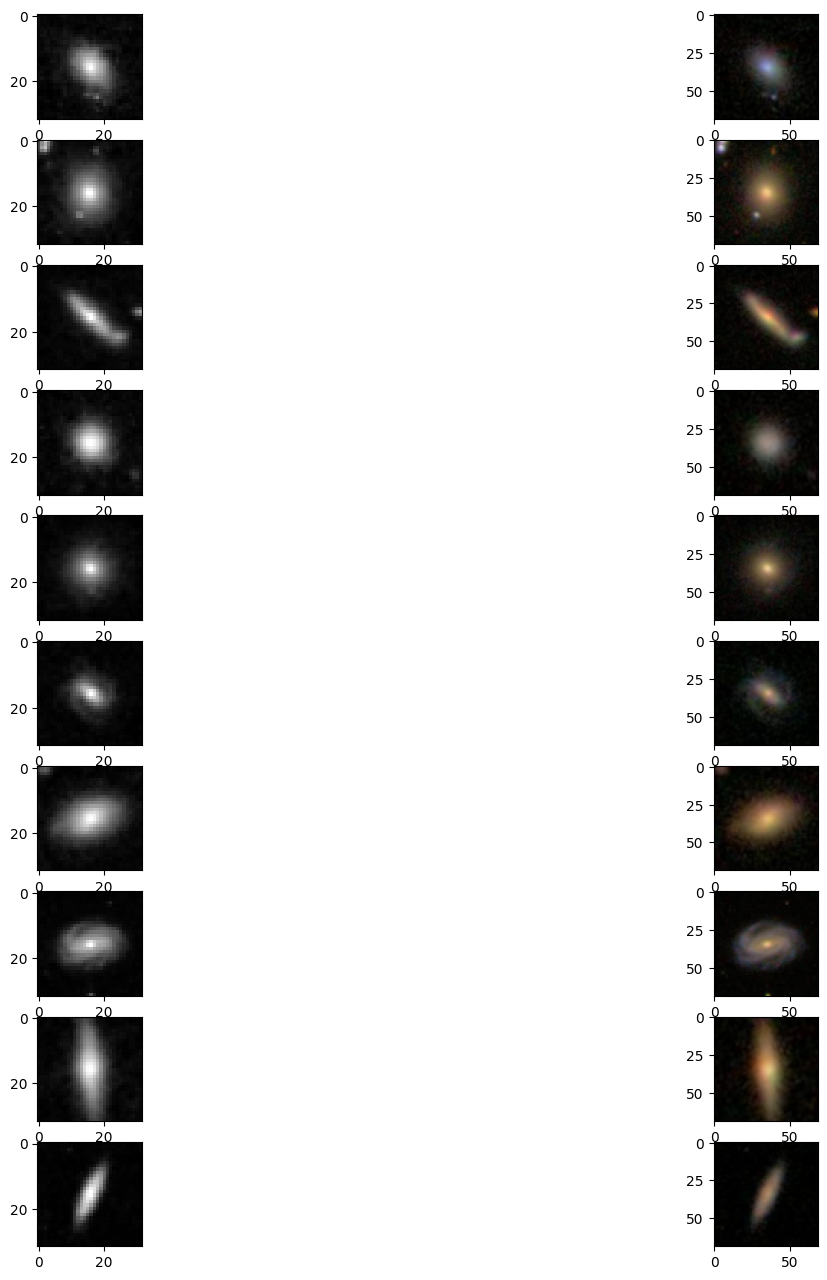

In [11]:

fig, axs=plt.subplots(10, 2, figsize=(16,16))
for i in range(10):
    axs[i, 0].imshow(train_loader.dataset[i][0][0], cmap='gray')
    axs[i, 1].imshow(Gal_train[i], cmap='gray')

In [12]:
#The convolutional NN
import torch.nn as nn
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_class=num_classes
        self.feature=nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2, stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=16*5*5, out_features=120),
            nn.Tanh(),
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=self.num_class)
        )
        
    
    def forward(self, x):
        return self.classifier(self.feature(x))

In [13]:
device=(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

cuda


In [14]:
from torchinfo import summary
model=LeNet5(10)
summary(model=model, input_size=(1, 3, 32, 32), col_width=20,
        col_names=['input_size', 'output_size', 'num_params', 'trainable'], row_settings=['var_names'], verbose=0)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
LeNet5 (LeNet5)                          [1, 3, 32, 32]       [1, 10]              --                   True
├─Sequential (feature)                   [1, 3, 32, 32]       [1, 16, 5, 5]        --                   True
│    └─Conv2d (0)                        [1, 3, 32, 32]       [1, 6, 28, 28]       456                  True
│    └─Tanh (1)                          [1, 6, 28, 28]       [1, 6, 28, 28]       --                   --
│    └─AvgPool2d (2)                     [1, 6, 28, 28]       [1, 6, 14, 14]       --                   --
│    └─Conv2d (3)                        [1, 6, 14, 14]       [1, 16, 10, 10]      2,416                True
│    └─Tanh (4)                          [1, 16, 10, 10]      [1, 16, 10, 10]      --                   --
│    └─AvgPool2d (5)                     [1, 16, 10, 10]      [1, 16, 5, 5]        --                   --
├─Sequential (classifi

In [15]:
num_features=len(features)
learning_rate=0.001
epochs=10

model=LeNet5(num_classes=num_features).to(device=device)
loss_fn=nn.CrossEntropyLoss()

optim=torch.optim.Adam(model.parameters(),lr=learning_rate)

total_steps=len(train_loader)

In [22]:
def train(train_loader, model, optimizer, loss_fn):
    model.train()
    for batch, (data, target) in enumerate(train_loader):
        data, target=data.to(device), target.to(device)
        
        output=model(data)
        loss=loss_fn(output, target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%100==0:
            print(f'Step: {batch*len(data)}/{len(train_loader.dataset)} Loss: {loss:.3f}')

In [23]:
def test(test_loader, model, loss_fn):
    model.eval()
    test_loss=0.0
    correct=0
    with torch.no_grad():
        for data, target in test_loader:
            data, target=data.to(device), target.to(device)
            
            output=model(data)
            test_loss+=loss_fn(output, target).item()
            prediction=output.argmax(dim=1, keepdim=True)
            correct+=prediction.eq(target.view_as(prediction)).sum().item()
    test_loss/=len(test_loader)
    acc=100*correct/len(test_loader.dataset)
    print(f"Test loss: {test_loss:.3f} Accuracy: {acc:.3f}")

In [24]:
for epoch in range(epochs):
    print(f"Epoch {epoch+1}\n======================================")
    train(train_loader, model, optim, loss_fn)
    test(test_loader, model, loss_fn)
print("Done!")
    

Epoch 1
Step: 0/17428 Loss: 0.528
Step: 6400/17428 Loss: 0.470
Step: 12800/17428 Loss: 0.616
Test loss: 0.770 Accuracy: 71.311
Epoch 2
Step: 0/17428 Loss: 0.665
Step: 6400/17428 Loss: 0.689
Step: 12800/17428 Loss: 0.584
Test loss: 0.647 Accuracy: 76.016
Epoch 3
Step: 0/17428 Loss: 0.497
Step: 6400/17428 Loss: 0.442
Step: 12800/17428 Loss: 0.571
Test loss: 0.661 Accuracy: 76.314
Epoch 4
Step: 0/17428 Loss: 0.341
Step: 6400/17428 Loss: 0.546
Step: 12800/17428 Loss: 0.643
Test loss: 0.702 Accuracy: 75.557
Epoch 5
Step: 0/17428 Loss: 0.444
Step: 6400/17428 Loss: 0.650
Step: 12800/17428 Loss: 0.721
Test loss: 0.638 Accuracy: 76.314
Epoch 6
Step: 0/17428 Loss: 0.467
Step: 6400/17428 Loss: 0.310
Step: 12800/17428 Loss: 0.592
Test loss: 0.686 Accuracy: 74.822
Epoch 7
Step: 0/17428 Loss: 0.565
Step: 6400/17428 Loss: 0.731
Step: 12800/17428 Loss: 0.408
Test loss: 0.665 Accuracy: 74.914
Epoch 8
Step: 0/17428 Loss: 0.446
Step: 6400/17428 Loss: 0.609
Step: 12800/17428 Loss: 0.491
Test loss: 0.660 A